# Train Target Model

In [1]:
import pandas as pd
import joblib
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from sklearn_ext import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import optuna
from scipy import stats
from datetime import datetime
import numpy as np
import plotnine as gg
from Bio.SeqUtils import ProtParamData
from tqdm import tqdm
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt


from datasets import dataset_list, get_sg_groups_df
import target_featurization as ft
from core import (lollipop_plot,
                  setup_plots,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)

In [2]:
setup_plots()

In [59]:
def lgbm_training_iteration(fold_df, seq_X, train_index, features,
                            aa_seq_df, aa_features, aa_width,
                            protein_domain_df,
                            conservation_df, cons_small_width,
                            cons_large_width,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param seq_X: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param aa_features: list
    :param aa_width: int
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param cons_small_width: int
    :param cons_large_width: int
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    endog_train_df = train_df[train_df.endogenous].copy()
    endog_train_df['Target Cut Length'] = endog_train_df['Target Cut Length'].astype(int)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(endog_train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                      aa_width=aa_width,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    full_train_df = train_df.merge(train_feature_df, how='left',
                                   on=['sgRNA Context Sequence', 'Target Cut Length',
                                       'Target Transcript', 'Target Cut %',
                                       'Orientation', 'dataset'])
    X_targ_train_val = (full_train_df[train_feature_cols].reset_index(drop=True)
                        .add_suffix(' (targ)')) # train and validation data
    X_seq_train_val = (seq_X.iloc[train_index,:].reset_index(drop=True)
                       .add_suffix(' (seq)'))
    X_train_val = pd.concat([X_seq_train_val, X_targ_train_val],
                            axis=1)
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    endog_test_df = test_df[test_df.endogenous].copy()
    endog_test_df['Target Cut Length'] = endog_test_df['Target Cut Length'].astype(int)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(endog_test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                    aa_width=aa_width,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    full_test_df = test_df.merge(test_feature_df, how='left',
                                 on=['sgRNA Context Sequence', 'Target Cut Length',
                                     'Target Transcript', 'Target Cut %',
                                     'Orientation', 'dataset'])
    X_targ_test = (full_test_df[test_feature_cols].reset_index(drop=True)
                   .add_suffix(' (targ)'))
    X_seq_test = (seq_X.iloc[test_index,:].reset_index(drop=True)
                  .add_suffix(' (seq)'))
    X_test = pd.concat([X_seq_test, X_targ_test],
                       axis=1)
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df, seq_X, features, aa_seq_df, aa_features, aa_width,
                       protein_domain_df,
                       conservation_df, cons_small_width, cons_large_width):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :param seq_X: Dataframe
    :param features: list
    :param aa_seq_df: DataFrame
    :param aa_features: list
    :param aa_width: int
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param cons_small_width: int
    :param cons_large_width: int
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, seq_X, train_index, features,
                                          aa_seq_df, aa_features, aa_width,
                                          protein_domain_df,
                                          conservation_df,
                                          cons_small_width, cons_large_width,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
codon_map_df = pd.read_csv('../data/external/codon_map.csv')

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

In [12]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df['tracr'] = ds.tracr
    sg_df['endogenous'] = ds.endogenous
    if ds.endogenous:
        design_df = ds.get_designs()
        sg_df = sg_df.merge(design_df, how='inner',
                            on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [13]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))

sg_df_class_groups = ft.add_target_columns(sg_df_class_groups)

In [17]:
sg_df_class_groups['dataset'].nunique()

7

In [18]:
sg_df_class_groups['sgRNA Sequence'].nunique()

46517

## Read Conservation Data

In [20]:
transcript_bases = list(sg_df_class_groups['Transcript Base']
                        .dropna()
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Calculate Sequence Features

In [21]:
seq_X = get_feature_df(sg_df_class_groups)

100%|██████████| 51087/51087 [02:19<00:00, 366.37it/s]


## Training Model

In [22]:
features = ['position', 'aa', 'domain', 'conservation']
aa_features = ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
               'Isoelectric Point', 'Secondary Structure']
aa_width = 16
cons_small_width = 2
cons_large_width = 16
n_trials = 50

In [60]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_class_groups, seq_X, features=features,
                               aa_seq_df=aa_seqs, aa_width=aa_width,
                               aa_features=aa_features, protein_domain_df=protein_domains,
                               conservation_df=conservation_df, cons_small_width=cons_small_width,
                               cons_large_width=cons_large_width)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-09-12 10:45:09,109] A new study created in memory with name: no-name-e7b65622-432b-4ecd-a82b-e34006b67ec5
[I 2021-09-12 10:45:55,426] Trial 0 finished with value: 0.41644437894625563 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.41644437894625563.
[I 2021-09-12 10:46:48,093] Trial 1 finished with value: 0.42791477565308245 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.42791477565308245.
[I 2021-09-12 10:47:43,827] Trial 2 finished with value: 0.4361425623082207 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.4361425623082207.
[I 2021-09-12 10:48:39,938] Trial 3 finished with value: 0.422757580553187 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.4361425623082207.
[I 2021-09-12 10:49:34,678] Trial 4 finished with value: 0.43595504298455834 and parameters: {'num_leaves': 74, 'min_child_samples': 132}

Number of finished trials: 50
Training Time: 0:43:38.248283
Best trial:
  Value: 0.44905688981444636
  Params: 
    num_leaves: 195
    min_child_samples: 82


In [62]:
# Using optimal parameters, retrain model with full dataset
endog_df = sg_df_class_groups[sg_df_class_groups.endogenous].copy()
endog_df['Target Cut Length'] = endog_df['Target Cut Length'].astype(int)
train_feature_df, train_feature_cols = ft.build_target_feature_df(endog_df,
                                                                  features=features,
                                                                  aa_seq_df=aa_seqs, aa_width=aa_width,
                                                                  aa_features=aa_features,
                                                                  protein_domain_df=protein_domains,
                                                                  conservation_df=conservation_df,
                                                                  cons_small_width=cons_small_width,
                                                                  cons_large_width=cons_large_width)
full_train_df = sg_df_class_groups.merge(train_feature_df, how='left',
                                         on=['sgRNA Context Sequence', 'Target Cut Length',
                                             'Target Transcript', 'Target Cut %',
                                             'Orientation', 'dataset'])
X_targ_train_val = (full_train_df[train_feature_cols].reset_index(drop=True)
                        .add_suffix(' (targ)')) # train and validation data
X_seq_train_val = (seq_X.reset_index(drop=True)
                   .add_suffix(' (seq)'))
X_train_val = pd.concat([X_seq_train_val, X_targ_train_val],
                        axis=1)
y_train_val = sg_df_class_groups['sgRNA Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1, random_state=7)
model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                  ('regressor', LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                   **trial.params))])
model.fit(X_train, y_train,
          regressor__early_stopping_rounds=20,
          regressor__eval_set=[(X_val, y_val)],
          regressor__verbose=1000)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[872]	valid_0's l2: 0.704588


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 LGBMRegressor(learning_rate=0.01, min_child_samples=82,
                               n_estimators=5000, n_jobs=8, num_leaves=195,
                               random_state=7))])

### Feature Importance

In [63]:
imputer = model['imputer']
regressor = model['regressor']
X_train_imputed = pd.DataFrame(imputer.transform(X_train),
                               columns=X_train.columns)

In [64]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_imputed)

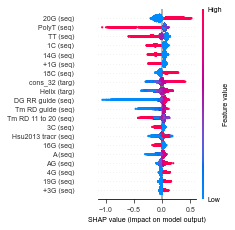

In [65]:
summary_legacy(shap_values, X_train, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=30)
#gpplot.savefig('../figures/target_shap_summary_plot.pdf', dpi=300)

In [66]:
shap_df = pd.DataFrame(shap_values, columns=X_train_imputed.columns)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False))

In [67]:
top_n = 20
top_features = shap_abs_importance.head(top_n).copy()
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])

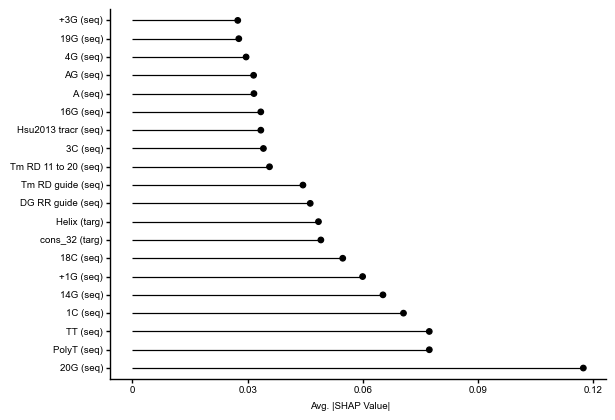

<ggplot: (8779656190230)>

In [68]:
g = lollipop_plot(top_features, 'feature', 'importance',
                  val_label='Avg. |SHAP Value|', cat_label='')
#g.save('../figures/target_shap_feature_importance.pdf', width=2.2, height=3)
g

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


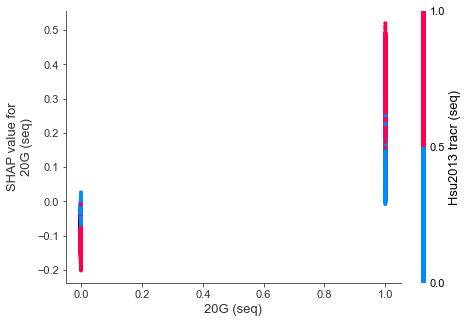

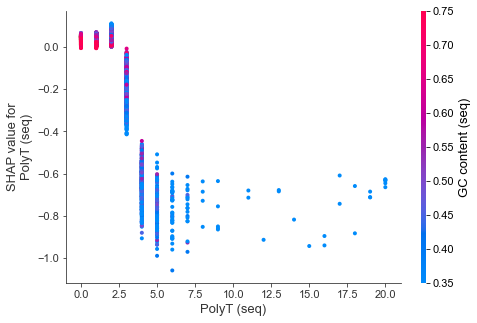

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


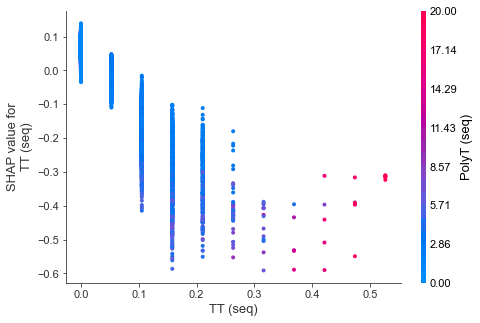

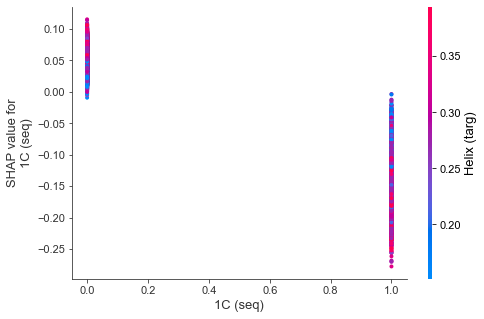

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


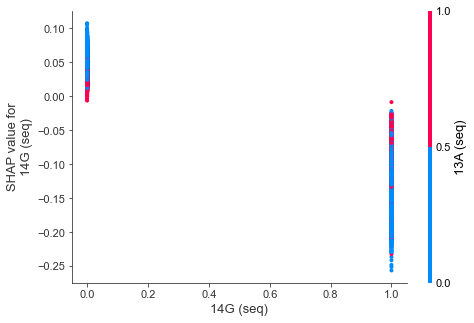

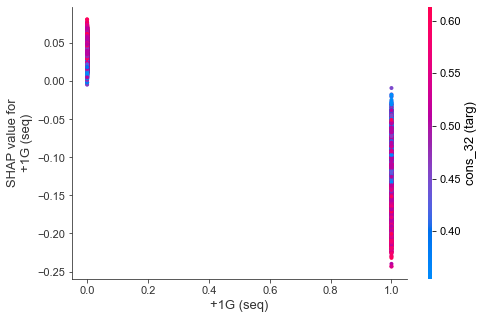

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


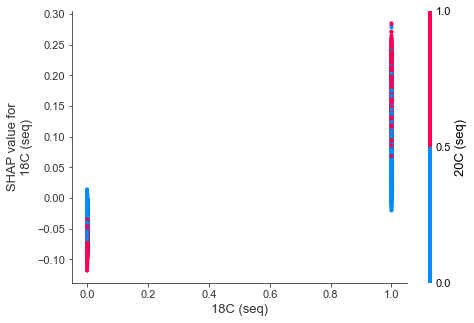

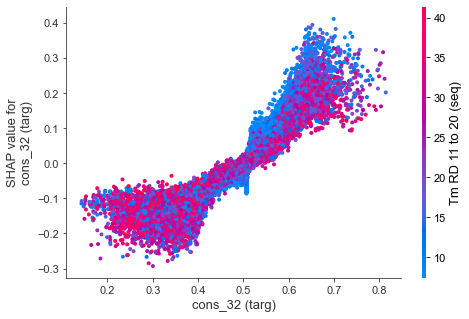

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


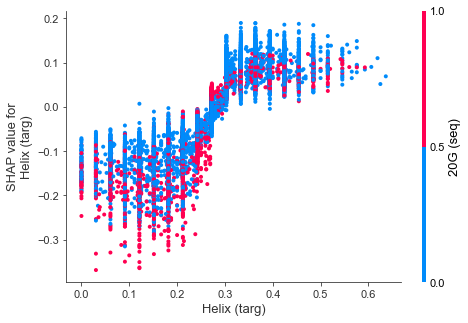

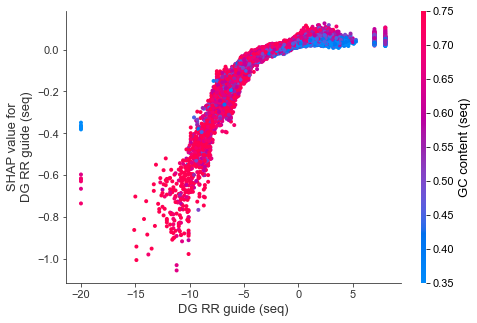

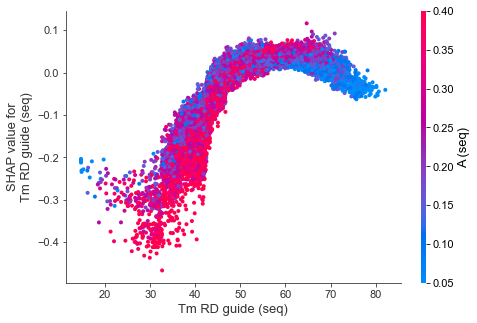

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


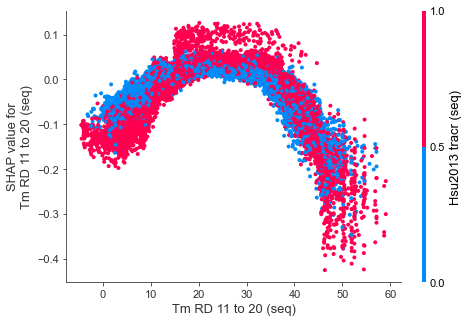

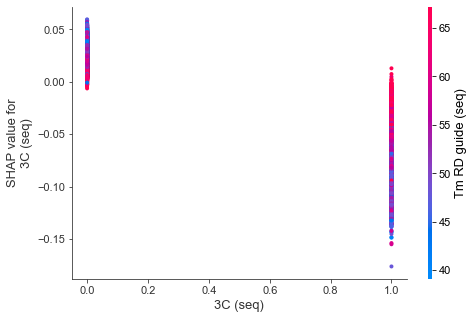

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


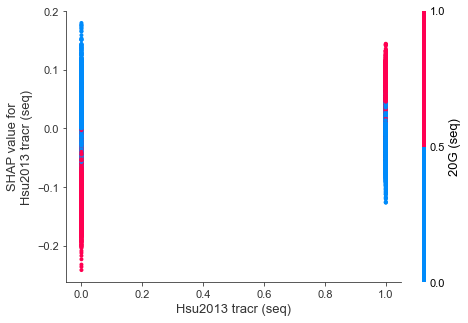

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


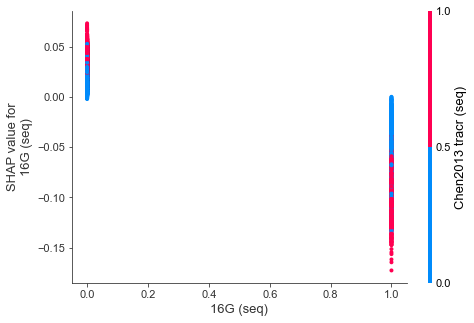

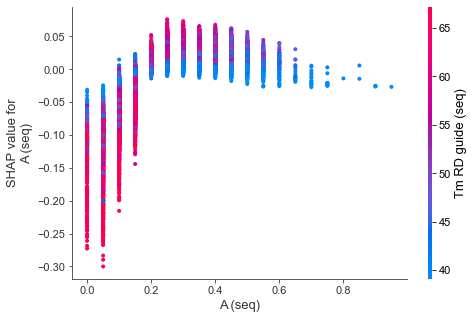

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


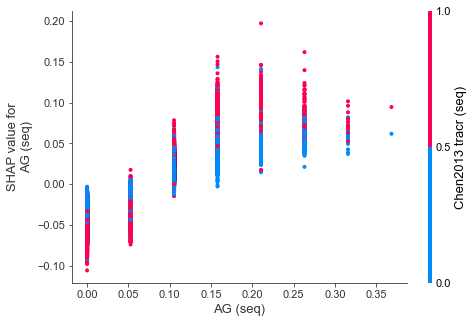

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


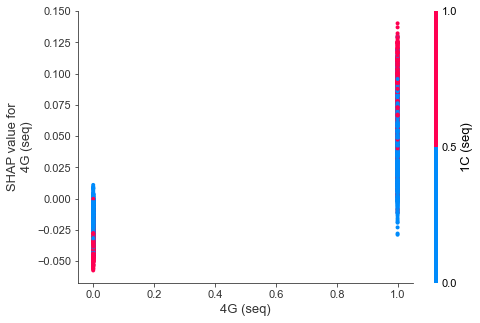

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


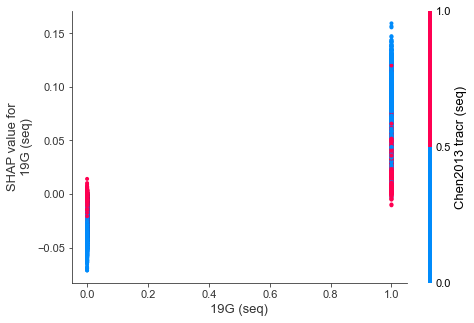

/Users/peterdeweirdt/opt/miniconda3/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


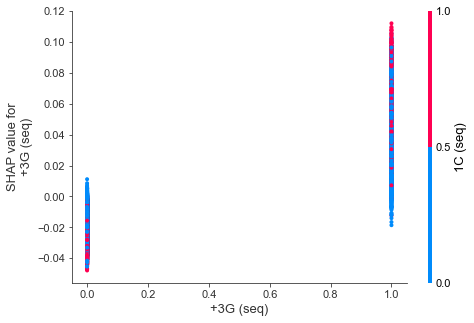

In [69]:
for feature in top_features['feature']:
    shap.dependence_plot(feature, shap_values, X_train_imputed)

In [70]:
interesting_features = []

In [71]:
for ft in interesting_features:
    dependence_legacy(ft, shap_values, X_train, show=False, dot_size=4,
                      default_fig_size=(1.5, 1.5),
                      text_size=7, legend_aspect=30,
                      nan_width=1)
    #gpplot.savefig('../figures/target_shap_' + ft + '_plot.pdf', dpi=300)

In [72]:
# dependence_legacy('Target Cut %', shap_values, X_train, show=False, dot_size=4,
#                       default_fig_size=(1.5, 1.5),
#                       text_size=7, legend_aspect=30,
#                       nan_width=1, interaction_index='Helix')
# plt.axvline(x=85, linestyle='--',
#             color='black', linewidth=1)
#gpplot.savefig('../figures/target_shap_' + 'Target Cut %' + '_plot.pdf', dpi=300)

## Amino Acid Importance

In [73]:
def get_shap_correlation(df):
    if (df['importance'].std() > 0) and (df['value'].std() > 0):
        return stats.pearsonr(df['importance'], df['value'])[0]
    else:
        return pd.NA


long_shap_df = (shap_df.reset_index()
                .rename({'index': 'train_index'}, axis=1)
                .melt(id_vars='train_index', var_name='feature',
                      value_name='importance'))
long_train_df = (X_train_imputed.reset_index(drop=True)
                 .reset_index()
                 .rename({'index': 'train_index'}, axis=1)
                 .melt(id_vars='train_index', var_name='feature',
                       value_name='value'))
long_shap_train_values = (long_shap_df.merge(long_train_df, how='inner',
                                             on=['train_index', 'feature']))
nonzero_shap_train_values = long_shap_train_values[long_shap_train_values['importance'] != 0]
shap_correlations = (nonzero_shap_train_values.groupby('feature')
                     .apply(lambda df: get_shap_correlation(df))
                     .reset_index(name='pearson_r'))
shap_correlations['direction'] = np.sign(shap_correlations['pearson_r'])
shap_directional_importance = (shap_abs_importance.merge(shap_correlations, how='inner',
                                                         on='feature'))
shap_directional_importance['directional_importance'] = (shap_directional_importance['direction'] *
                                                         shap_directional_importance['importance'])
shap_directional_importance = shap_directional_importance.sort_values('directional_importance')

In [74]:
shap_directional_importance

,feature,importance,pearson_r,direction,directional_importance
1,PolyT (seq),0.077292,-0.730163,-1.0,-0.077292
2,TT (seq),0.077280,-0.937372,-1.0,-0.077280
3,1C (seq),0.070564,-0.956477,-1.0,-0.070564
4,14G (seq),0.065220,-0.963930,-1.0,-0.065220
5,+1G (seq),0.059930,-0.970653,-1.0,-0.059930
...,...,...,...,...,...
9,DG RR guide (seq),0.046288,0.786969,1.0,0.046288
8,Helix (targ),0.048433,0.851461,1.0,0.048433
7,cons_32 (targ),0.049058,0.885219,1.0,0.049058
6,18C (seq),0.054752,0.912546,1.0,0.054752


In [75]:
aa_directional_importance = (shap_directional_importance[shap_directional_importance.feature
                             .str.contains('^[A-Z] \(targ\)')]
                             .copy())
aa_directional_importance['feature'] = aa_directional_importance['feature'].str.split(' ', expand=True)[0]
aa_directional_importance['feature'] = pd.Categorical(aa_directional_importance['feature'],
                                                      categories=aa_directional_importance['feature'])

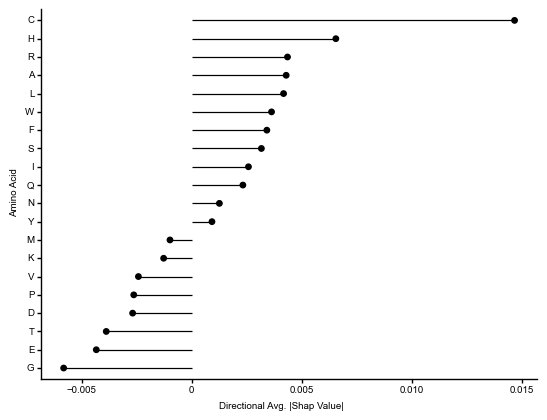

<ggplot: (8779622518336)>

In [76]:
g = lollipop_plot(aa_directional_importance, 'feature', 'directional_importance', cat_label='Amino Acid',
                  val_label='Directional Avg. |Shap Value|')
#g.save('../figures/target_model_aa_directional_importance.pdf', width=3, height=3)
g

## Amino Acid Covariates

In [77]:
aa_nt_frac = (codon_map_df.groupby('Amino Acid')
              .agg(joined_codons = ('Codon', ''.join))
              .reset_index())
for nt in ['A', 'C', 'T', 'G']:
    aa_nt_frac[nt + ' frac.'] = aa_nt_frac['joined_codons'].str.count(nt)/aa_nt_frac['joined_codons'].str.len()


In [78]:
def make_physiochem_df(physio_dict, name):
    df = (pd.DataFrame.from_dict(physio_dict, orient='index')
          .reset_index()
          .rename({'index': 'Amino Acid',
                   0: name}, axis=1))
    return df

hydrophobicity_df = make_physiochem_df(ProtParamData.kd, 'hydrophobicity')
hydrophilicity_df = make_physiochem_df(ProtParamData.hw, 'hydrophilicity')
sa_df = make_physiochem_df(ProtParamData.em, 'surface accessibility')
ste_df = make_physiochem_df(ProtParamData.ja, 'surface transfer energy')
flex_df = make_physiochem_df(ProtParamData.Flex, 'flexibility')
all_physiochem_df = aa_nt_frac
for df in [hydrophobicity_df, hydrophilicity_df, sa_df, ste_df, flex_df]:
    all_physiochem_df = all_physiochem_df.merge(df, how='inner', on='Amino Acid')
all_physiochem_df = all_physiochem_df.merge(aa_directional_importance[['feature',
                                                                       'directional_importance']], how='left',
                                            left_on='Amino Acid', right_on='feature')

While we do see a relatively strong correlation with the fraction of G within an amino acid's codons,
95% confidence interval suggests this correlation is skewed closer to 0, largely driven by Glycine.

In [79]:
nboots = 1000
bootstrap_aa_cor_list = []
for i in tqdm(range(nboots)):
    resampled_pysiochem_df = (all_physiochem_df
                              .sample(frac=1, replace=True,
                                      random_state=i))
    correlations = resampled_pysiochem_df.corr().loc[:,'directional_importance'].rename(i)
    bootstrap_aa_cor_list.append(correlations)

pysiochem_core_ci = (pd.concat(bootstrap_aa_cor_list, axis=1)
                     .reset_index()
                     .rename({'index': 'property'}, axis=1)
                     .melt(id_vars='property', var_name='sample', value_name='pearson')
                     .groupby('property')
                     .agg(pearson_975 = ('pearson', lambda x: np.percentile(x, 97.5)),
                          pearson_025 = ('pearson', lambda x: np.percentile(x, 2.5)),
                          median_pearson = ('pearson', lambda x: np.percentile(x, 50)))
                     .reset_index()
                     .sort_values('median_pearson'))
pysiochem_core_ci['property'] = pd.Categorical(pysiochem_core_ci['property'],
                                               categories=pysiochem_core_ci['property'])

100%|██████████| 1000/1000 [00:00<00:00, 2473.00it/s]


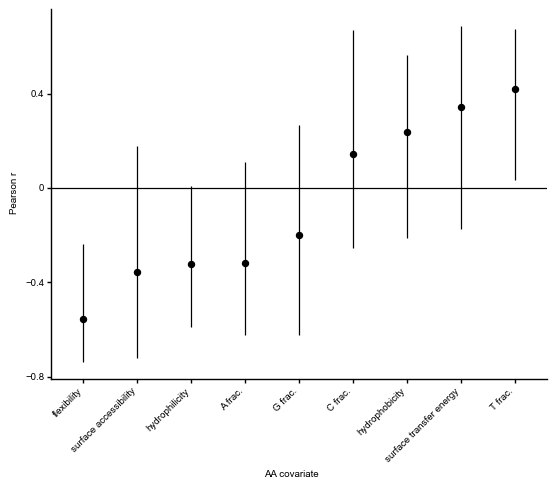

<ggplot: (8779588120610)>

In [80]:
g = (gg.ggplot(data=pysiochem_core_ci[pysiochem_core_ci['property'] != 'directional_importance']) +
     gg.aes(x='property', y='median_pearson',
            ymin='pearson_025', ymax='pearson_975') +
     gg.geom_pointrange() +
     gg.geom_hline(yintercept=0) +
     gg.theme(axis_text_x=gg.element_text(angle=45, hjust=1, vjust=1)) +
     gg.xlab('AA covariate') +
     gg.ylab('Pearson r'))
#g.save('../figures/target_aa_physiochem_cor.pdf', width=2.3, height=2.3)
g

Text(2.7787500000000023, 0.5, 'Directional Importance')

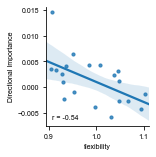

In [81]:
sns.lmplot(data=all_physiochem_df, x='flexibility', y='directional_importance', truncate=False,
           scatter_kws={'s': 10}, height=2.2)
gpplot.add_correlation(data=all_physiochem_df, x='flexibility', y='directional_importance',
                       loc='lower left')
plt.ylabel('Directional Importance')
#gpplot.savefig('../figures/target_model_gfrac_cor.pdf')

## Output

In [82]:
joblib.dump(model, '../models/seq_target_model.pkl')

['../models/seq_target_model.pkl']